In [1]:
# Load libraries
import numpy
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [2]:
# Load dataset
data = read_csv('starting_to_work.csv',index_col=0)


In [4]:
data = data[['price_per_square','squares', 'max_floor', 'metro_1km','latitude', 'longitude',
       'parkings_1km', 'distance_to_center',
       'mean_distr_pps']]

### 3. Validation Dataset

In [5]:
# Split-out validation dataset
X = data[[ 'squares', 'max_floor', 'metro_1km','latitude', 'longitude',
       'parkings_1km', 'distance_to_center',
       'mean_distr_pps']]
Y = data['price_per_square']
validation_size = 0.2
seed = 999
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
test_size=validation_size, random_state=seed)

### 4. Evaluate Algorithms: Baseline

In [7]:
# Test options and evaluation metric
num_folds = 2
seed = 999
scoring = 'neg_mean_absolute_percentage_error'

In [10]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor(n_neighbors=5)))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.294483 (0.002066)
LASSO: -0.294480 (0.002061)
EN: -0.294512 (0.001439)
KNN: -0.307437 (0.000029)
CART: -0.317022 (0.002076)
SVR: -0.335565 (0.006456)


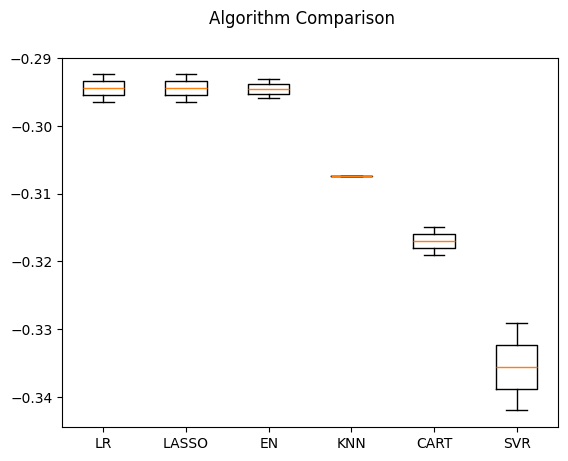

In [11]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### 5. Evaluate Algorithms: Standardize Data

In [12]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',
LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO',
Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN',
ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',
KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',
DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.294483 (0.002066)
ScaledLASSO: -0.294483 (0.002066)
ScaledEN: -0.299320 (0.005157)
ScaledKNN: -0.287242 (0.000674)
ScaledCART: -0.321961 (0.004440)
ScaledSVR: -0.335535 (0.006461)


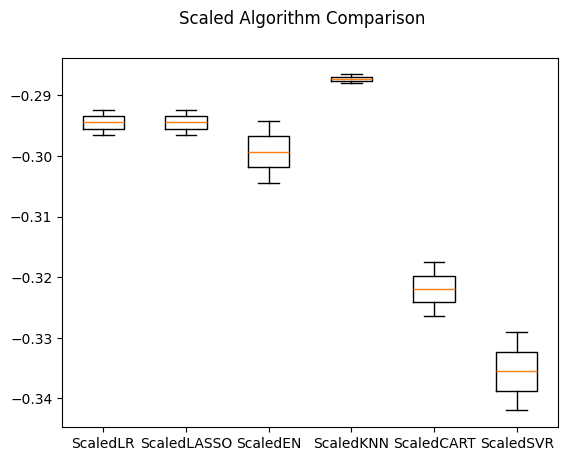

In [13]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### 6. Algorithm Tuning

In [14]:
# KNN Algorithm tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = numpy.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.284710 using {'n_neighbors': 11}
-0.310613 (0.007706) with: {'n_neighbors': 1}
-0.290752 (0.003075) with: {'n_neighbors': 3}
-0.287525 (0.000890) with: {'n_neighbors': 5}
-0.285658 (0.000682) with: {'n_neighbors': 7}
-0.286933 (0.000157) with: {'n_neighbors': 9}
-0.284710 (0.001874) with: {'n_neighbors': 11}
-0.285289 (0.003279) with: {'n_neighbors': 13}
-0.288226 (0.003318) with: {'n_neighbors': 15}
-0.290783 (0.003547) with: {'n_neighbors': 17}
-0.291729 (0.002500) with: {'n_neighbors': 19}
-0.292876 (0.002914) with: {'n_neighbors': 21}


### 7. Ensemble Methods

In [21]:
# ensembles
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB',
AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM',
GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF',
RandomForestRegressor(n_estimators=10))])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET',
ExtraTreesRegressor(n_estimators=10))])))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: -0.286024 (0.002168)
GBM: -0.260961 (0.003879)
RF: -0.247773 (0.004019)
ET: -0.246670 (0.004226)


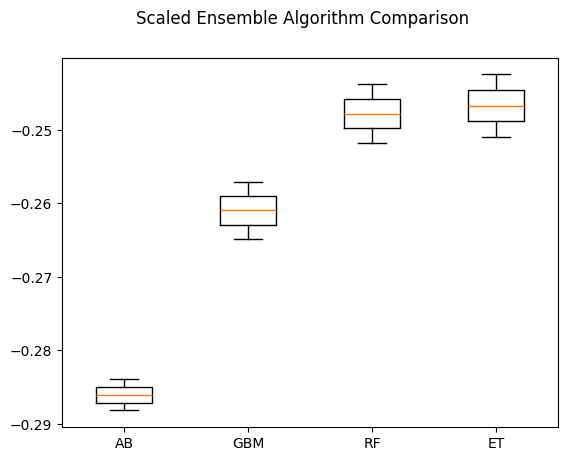

In [22]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [27]:
# Standardize the dataset
pipelines = []
pipelines.append(('LR',LinearRegression()))
pipelines.append(('LASSO',Lasso()))
pipelines.append(('EN',ElasticNet()))
pipelines.append(('KNN',KNeighborsRegressor()))
pipelines.append(('CART',DecisionTreeRegressor()))
pipelines.append(('SVR', SVR()))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.294483 (0.002066)
LASSO: -0.294480 (0.002061)
EN: -0.294512 (0.001439)
KNN: -0.307437 (0.000029)
CART: -0.314590 (0.008017)
SVR: -0.335565 (0.006456)


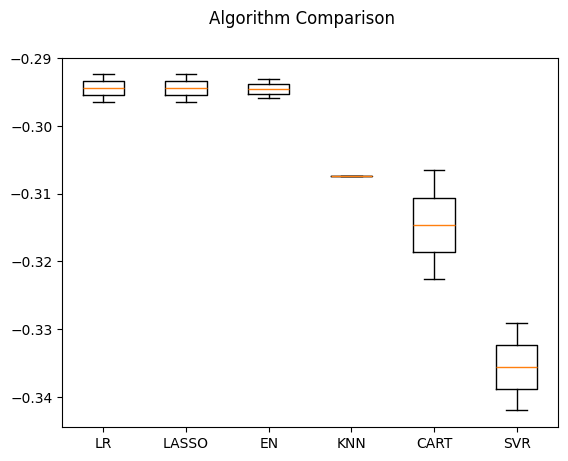

In [29]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### 6. Algorithm Tuning

In [ ]:
# KNN Algorithm tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = numpy.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.284710 using {'n_neighbors': 11}
-0.310613 (0.007706) with: {'n_neighbors': 1}
-0.290752 (0.003075) with: {'n_neighbors': 3}
-0.287525 (0.000890) with: {'n_neighbors': 5}
-0.285658 (0.000682) with: {'n_neighbors': 7}
-0.286933 (0.000157) with: {'n_neighbors': 9}
-0.284710 (0.001874) with: {'n_neighbors': 11}
-0.285289 (0.003279) with: {'n_neighbors': 13}
-0.288226 (0.003318) with: {'n_neighbors': 15}
-0.290783 (0.003547) with: {'n_neighbors': 17}
-0.291729 (0.002500) with: {'n_neighbors': 19}
-0.292876 (0.002914) with: {'n_neighbors': 21}


### 7. Ensemble Methods

In [30]:
# ensembles
ensembles = []
ensembles.append(('AB',AdaBoostRegressor()))
ensembles.append(('GBM',GradientBoostingRegressor()))
ensembles.append((('RF',RandomForestRegressor(n_estimators=100))))
ensembles.append(('ET',ExtraTreesRegressor(n_estimators=100)))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: -0.290178 (0.010181)
GBM: -0.260837 (0.003925)
RF: -0.246821 (0.001966)
ET: -0.245405 (0.002621)


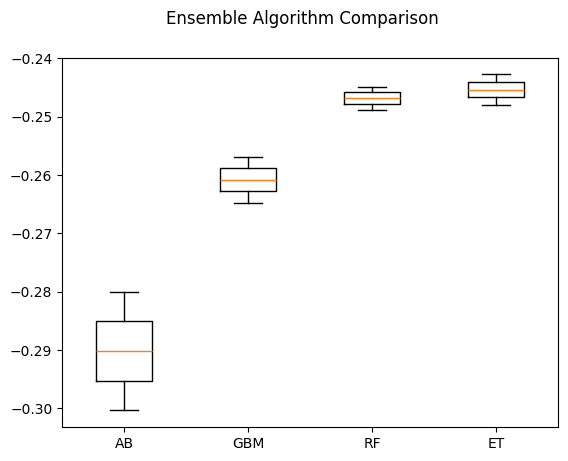

In [32]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [33]:
# Tune scaled GBM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=numpy.array([50,100,150,200,250,300,350,400]))
model = ExtraTreesRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

In [25]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.827918 using {'n_estimators': 50}
-0.827918 (0.081196) with: {'n_estimators': 50}
-0.850572 (0.082175) with: {'n_estimators': 100}
-0.874807 (0.080039) with: {'n_estimators': 150}
-0.881524 (0.075600) with: {'n_estimators': 200}
-0.889651 (0.072438) with: {'n_estimators': 250}
-0.893273 (0.074002) with: {'n_estimators': 300}
-0.894051 (0.075392) with: {'n_estimators': 350}
-0.894182 (0.076131) with: {'n_estimators': 400}


### 8. Finalize Model

In [43]:
rfc = RandomForestRegressor(n_estimators=100)
rfc.fit(X_train, Y_train)
display(rfc.score(X_train, Y_train))

0.9145987163308532

In [45]:
predictions1 = rfc.predict(X_train)
#Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(Y_train, predictions1))
print(rmse)
print(mean_absolute_error(Y_train, predictions1))
print(mean_absolute_percentage_error(Y_train, predictions1))

23494.20405387545
16818.03089498905
0.08691612252633917


In [46]:
predictions2 = rfc.predict(X_validation)
#Calculate the root mean squared error
display(rfc.score(X_validation, Y_validation))
rmse = np.sqrt(mean_squared_error(Y_validation, predictions2))
print(rmse)
print(mean_absolute_error(Y_validation, predictions2))
print(mean_absolute_percentage_error(Y_validation, predictions2))

0.43091214703957814

58777.1393883048
43643.96313502109
0.218066931242153


In [47]:
import pickle

with open('rfc.pkl', 'wb') as file:
    pickle.dump(rfc, file)

# # Загрузка модели из файла
# with open('rfc.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)

In [ ]:
import pickle

with open(r'c:\Users\pelik\Documents/anya_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [48]:
rfc = ExtraTreesRegressor(n_estimators=50)
rfc.fit(X_train, Y_train)
display(rfc.score(X_train, Y_train))

0.9999725831378852

In [49]:
predictions1 = rfc.predict(X_train)
#Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(Y_train, predictions1))
print(rmse)
print(mean_absolute_error(Y_train, predictions1))
print(mean_absolute_percentage_error(Y_train, predictions1))

420.95668530542196
28.838351822570218
0.00010741695799984229


In [50]:
predictions2 = rfc.predict(X_validation)
#Calculate the root mean squared error
display(rfc.score(X_validation, Y_validation))
rmse = np.sqrt(mean_squared_error(Y_validation, predictions2))
print(rmse)
print(mean_absolute_error(Y_validation, predictions2))
print(mean_absolute_percentage_error(Y_validation, predictions2))

0.39543973598473947

60581.2998161756
43714.8184050633
0.22003005178952015


In [51]:
import pickle

with open('extr.pkl', 'wb') as file:
    pickle.dump(rfc, file)

# # Загрузка модели из файла
# with open('rfc.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)